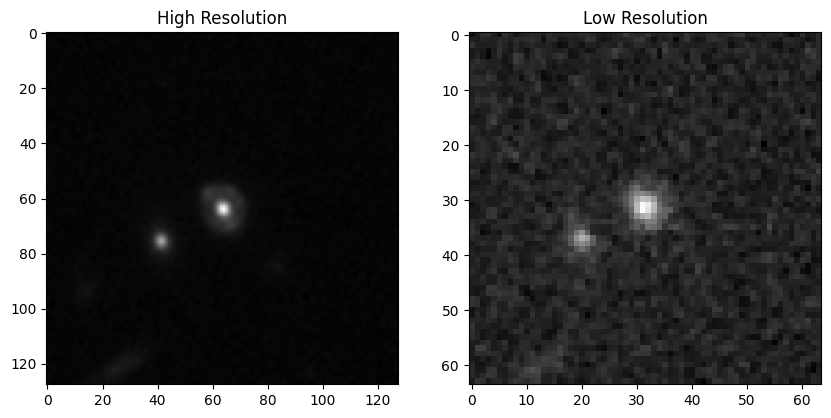

High Resolution Size:  (128, 128, 1)
Low Resolution Size:  (64, 64, 1)
High Resolution Range:  0.003715881 1.0158046
Low Resolution Range:  0.010345323 0.99508697


In [1]:
import os
import numpy as np




hr = "3b/HR/HR_3.npy"
lr = "3b/LR/LR_3.npy"

hr = np.load(hr)
lr = np.load(lr)
#reshaping
hr = np.transpose(hr, (1, 2, 0))
lr = np.transpose(lr, (1, 2, 0))

#plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(hr , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(lr , cmap='gray')
ax[1].set_title("Low Resolution")
plt.show()

#size
print("High Resolution Size: ", hr.shape)
print("Low Resolution Size: ", lr.shape)

#print range of pixel values
print("High Resolution Range: ", np.min(hr), np.max(hr))
print("Low Resolution Range: ", np.min(lr), np.max(lr))


In [2]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return low_res_image , high_res_image


#sizes
high_res_folder = "3b/HR"
low_res_folder = "3b/LR"

high_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),
])
                                        
low_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)






Number of samples:  300
Sample 0:  torch.Size([1, 64, 64]) torch.Size([1, 128, 128])


In [4]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


class ChannelAttentionLayer(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ChannelAttentionLayer, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channel, channel // reduction_ratio, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction_ratio, channel, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, features):
        attention = self.global_pooling(features)
        attention = self.channel_attention(attention)
        return features * attention

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ResidualChannelAttentionBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            ChannelAttentionLayer(channel, reduction_ratio)
        )

    def forward(self, input_features):
        residual = self.conv_block(input_features)
        return input_features + residual


class ResidualGroup(nn.Module):
    def __init__(self, channel, num_blocks, reduction_ratio):
        super(ResidualGroup, self).__init__()
        blocks = [ResidualChannelAttentionBlock(channel, reduction_ratio) for _ in range(num_blocks)]
        blocks.append(nn.Conv2d(channel, channel, kernel_size=3, padding=1))
        self.group = nn.Sequential(*blocks)

    def forward(self, group_input):
        residual = self.group(group_input)
        return group_input + residual  # Use non-inplace addition

class ResidualChannelAttentionNetwork(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, feature_dim=64, num_residual_groups=2, num_rcab=4, reduction_ratio=16):
        super(ResidualChannelAttentionNetwork, self).__init__()
        self.initial_conv = nn.Conv2d(num_channels, feature_dim, kernel_size=3, padding=1)

        self.residual_groups = nn.Sequential(
            *[ResidualGroup(feature_dim, num_rcab, reduction_ratio) for _ in range(num_residual_groups)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

        self.final_conv = nn.Conv2d(feature_dim, num_channels, kernel_size=3, padding=1)

    def forward(self, input_images):
        features = self.initial_conv(input_images)
        residual = self.residual_groups(features)
        features = features + residual  # Use non-inplace addition here as well
        upsampled = self.upsample(features)
        output = self.final_conv(upsampled)
        return output

In [5]:
sample = torch.randn(1, 1, 64, 64)
model = ResidualChannelAttentionNetwork()
output = model(sample)
print(output.shape)

torch.Size([1, 1, 128, 128])


In [7]:
import alive_progress
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(176))

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

save_path = "model_3b/"
epochs = 200

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=1)

def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=1)

def calculate_mmse(img1, img2):
    return np.mean((img1 - img2) ** 2)

#AdamW witn reduce on plateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
#
#cosine annealing learning rate
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001 )
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True  )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
best_mse = 1.0
best_ssim = 0.0
best_psnr = 0.0


for epoch in range(epochs):
    model.train()
    for lr, hr in data_loader:
        lr = lr.to(device)
        hr = hr.to(device)
        model.to(device)


        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #cheduler.step(loss)

    model = model.eval()
    ssim_scores = []
    psnr_scores = []
    mmse_scores = []
    
    for lr, hr in test_loader:
        with torch.no_grad():
            model.to("cuda")
            sr = model(lr.to("cuda"))
            sr = sr.squeeze(1).to("cpu").detach().numpy()
            hr = hr.squeeze(1).numpy()
            
            for i in range(sr.shape[0]):
                ssim_scores.append(calculate_ssim(sr[i], hr[i]))
                psnr_scores.append(calculate_psnr(sr[i], hr[i]))
                mmse_scores.append(calculate_mmse(sr[i], hr[i]))
    print("Average SSIM: ", np.mean(ssim_scores))
    print("Average PSNR: ", np.mean(psnr_scores))
    print("Average MMSE: ", np.mean(mmse_scores))

    if np.mean(ssim_scores) > best_ssim:
        best_ssim = np.mean(ssim_scores)
        torch.save(model.state_dict(), save_path + f"3b_RCAN.pth")


    





/home/arnesh/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Average SSIM:  0.7291387249643135
Average PSNR:  28.52633582019467
Average MMSE:  0.0014891251
Average SSIM:  0.7033348403772427
Average PSNR:  29.34996946066918
Average MMSE:  0.0012681384
Average SSIM:  0.7833479870947794
Average PSNR:  29.792714898107022
Average MMSE:  0.0011478896
Average SSIM:  0.8022020117859486
Average PSNR:  30.145361261652315
Average MMSE:  0.0010613269
Average SSIM:  0.8217825989051538
Average PSNR:  30.37314666145284
Average MMSE:  0.0010145404
Average SSIM:  0.8228738607128705
Average PSNR:  30.842648408535457
Average MMSE:  0.00092285435
Average SSIM:  0.823807972997669
Average PSNR:  31.318453811179044
Average MMSE:  0.00084188796
Average SSIM:  0.8254442647016937
Average PSNR:  31.396064778466382
Average MMSE:  0.0008148441
Average SSIM:  0.786488255777711
Average PSNR:  31.47905008404524
Average MMSE:  0.00079298083
Average SSIM:  0.8392181360465105
Average PSNR:  32.06574062941471
Average MMSE:  0.0007209869
Average SSIM:  0.8029450144866868
Average PS

In [8]:
import alive_progress
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(176))

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

save_path = "model_3b/"
epochs = 200

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=1)

def calculate_psnr(img1, img2):
    return psnr(img1, img2, data_range=1)

def calculate_mmse(img1, img2):
    return np.mean((img1 - img2) ** 2)

#AdamW witn reduce on plateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
#
#cosine annealing learning rate
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001 )
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True  )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
best_mse = 1.0
best_ssim = 0.0
best_psnr = 0.0


for epoch in range(epochs):
    model.train()
    for lr, hr in data_loader:
        lr = lr.to(device)
        hr = hr.to(device)
        model.to(device)


        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #cheduler.step(loss)

    model = model.eval()
    ssim_scores = []
    psnr_scores = []
    mmse_scores = []
    
    for lr, hr in test_loader:
        with torch.no_grad():
            model.to("cuda")
            sr = model(lr.to("cuda"))
            sr = sr.squeeze(1).to("cpu").detach().numpy()
            hr = hr.squeeze(1).numpy()
            
            for i in range(sr.shape[0]):
                ssim_scores.append(calculate_ssim(sr[i], hr[i]))
                psnr_scores.append(calculate_psnr(sr[i], hr[i]))
                mmse_scores.append(calculate_mmse(sr[i], hr[i]))
    print("Average SSIM: ", np.mean(ssim_scores))
    print("Average PSNR: ", np.mean(psnr_scores))
    print("Average MMSE: ", np.mean(mmse_scores))

    if np.mean(ssim_scores) > best_ssim:
        best_ssim = np.mean(ssim_scores)
        torch.save(model.state_dict(), save_path + f"3b_RCAN.pth")


    





Average SSIM:  0.8687253664898146
Average PSNR:  35.56741324882069
Average MMSE:  0.00043476405
Average SSIM:  0.8379317785921473
Average PSNR:  34.95333029533908
Average MMSE:  0.00047484145
Average SSIM:  0.8767060916169089
Average PSNR:  35.789444224630486
Average MMSE:  0.00040741998
Average SSIM:  0.8884518811149358
Average PSNR:  35.96529296261279
Average MMSE:  0.00040882238
Average SSIM:  0.8573445071459709
Average PSNR:  35.118273371172144
Average MMSE:  0.00048524913
Average SSIM:  0.8875225133564861
Average PSNR:  36.01992667376592
Average MMSE:  0.00041124297
Average SSIM:  0.8782075153751495
Average PSNR:  35.75245043640773
Average MMSE:  0.00043238388
Average SSIM:  0.882982048815425
Average PSNR:  35.84327675151212
Average MMSE:  0.00042788213
Average SSIM:  0.8039457809197299
Average PSNR:  34.51552778412986
Average MMSE:  0.00049133174
Average SSIM:  0.8857956862903358
Average PSNR:  36.000188792751814
Average MMSE:  0.000420533
Average SSIM:  0.8847898612739697
Averag

KeyboardInterrupt: 

In [12]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size] , generator=torch.Generator().manual_seed(176))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
for lr, hr in data_loader:
    lr = lr.to(device)
    hr = hr.to(device)
    model.to(device)


    optimizer.zero_grad()
    sr = model(lr)
    loss = criterion(sr, hr)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    #cheduler.step(loss)

model = model.eval()
ssim_scores = []
psnr_scores = []
mmse_scores = []

for lr, hr in test_loader:
    with torch.no_grad():
        model.to("cuda")
        sr = model(lr.to("cuda"))
        sr = sr.squeeze(1).to("cpu").detach().numpy()
        hr = hr.squeeze(1).numpy()
        
        for i in range(sr.shape[0]):
            ssim_scores.append(calculate_ssim(sr[i], hr[i]))
            psnr_scores.append(calculate_psnr(sr[i], hr[i]))
            mmse_scores.append(calculate_mmse(sr[i], hr[i]))
print("Average SSIM: ", np.mean(ssim_scores))
print("Average PSNR: ", np.mean(psnr_scores))

Average SSIM:  0.8888007752760119
Average PSNR:  41.986021223300085


In [22]:
#SSIM, PSNR, MMSE on test data
model = ResidualChannelAttentionNetwork()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
pretrained_path = "model_3b/3b_RCAN.pth"
model.load_state_dict(torch.load(pretrained_path))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range= img2.max() - img2.min())

def calculate_psnr(img1, img2):
    return psnr(img1, img2)

def calculate_mmse(img1, img2):
    return np.mean((img1 - img2) ** 2)

model = model.eval()
ssim_scores = []
psnr_scores = []
mmse_scores = []
for lr, hr in test_loader:
    with torch.no_grad():
        model.to("cuda")
        sr = model(lr.to("cuda"))
        sr = sr.squeeze(1).to("cpu").detach().numpy()
        hr = hr.squeeze(1).numpy()
        
        for i in range(sr.shape[0]):
            ssim_scores.append(calculate_ssim(sr[i], hr[i]))
            psnr_scores.append(calculate_psnr(sr[i], hr[i]))
            mmse_scores.append(calculate_mmse(sr[i], hr[i]))

print("Average SSIM: ", np.mean(ssim_scores))
print("Average PSNR: ", np.mean(psnr_scores))
print("Average MMSE: ", np.mean(mmse_scores))
    

Average SSIM:  0.888800775276012
Average PSNR:  41.986021223300085
Average MMSE:  0.00040882084


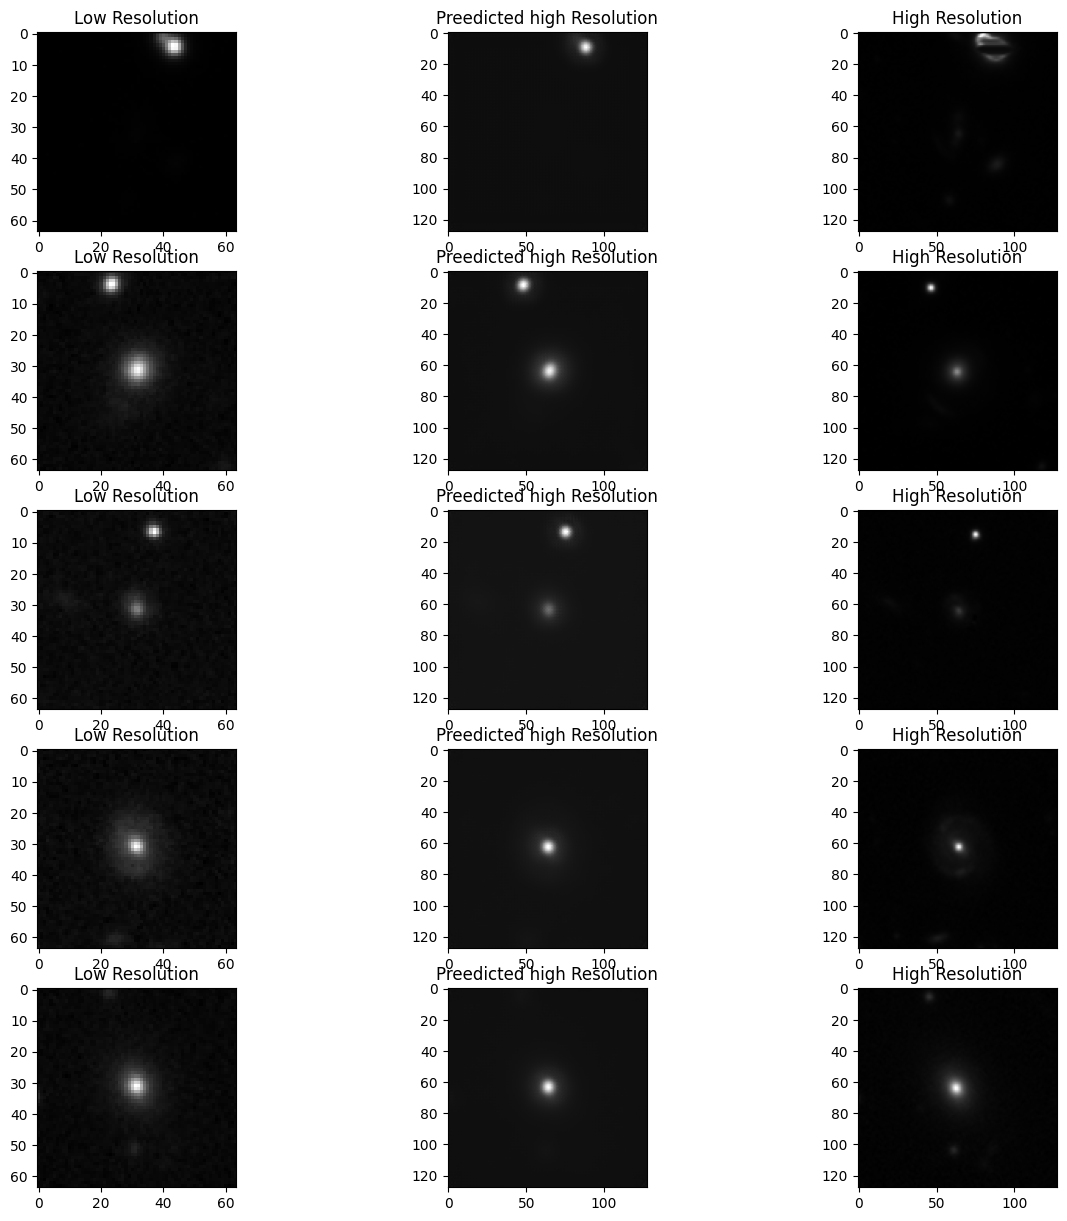

In [19]:
#plot first 5 images
import matplotlib.pyplot as plt
model = model.eval()
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

for i, (lr, hr) in enumerate(test_loader):
    if i == 5:
        break
    with torch.no_grad():
        model.to("cuda")
        sr = model(lr.to("cuda"))
        sr = sr.squeeze(1).to("cpu").detach().numpy()
        hr = hr.squeeze(1).numpy()
        ax[i, 0].imshow(lr.squeeze(1).numpy().squeeze(), cmap='gray')
        ax[i, 0].set_title("Low Resolution")
        ax[i, 1].imshow(sr.squeeze(), cmap='gray')
        ax[i, 1].set_title("Preedicted high Resolution")
        ax[i, 2].imshow(hr.squeeze(), cmap='gray')
        ax[i, 2].set_title("High Resolution")